In [156]:
import pandas as pd
import numpy as np

In [306]:
df_1 = pd.read_csv("data/raw/2020-2021.csv")


In [308]:
#since there are 106 columns in the dataset, I will extract the 20 key columns to work with
#So now I'll create a list with the columns I want
base_cols = [
   
    
    "HomeTeam",
    "AwayTeam",
    "FTHG",
    "FTAG",
    "FTR",
    "B365H",
    "B365D",
    "B365A",
    "HTHG",
    "HTAG",
    "HTR",
    "Attendance",
    "Referee",
    "HS",
    "AS",
    "HST",
    "AST",
    "HC",
    "AC",
    "HF",
    "AF",
    "HFKC",
    "AFKC",
    "HO",
    "AO",
    "HY",
    "AY",
    "HR",
    "AR",
    "HBP",
    "ABP",
    "Time",
    "Date",
    "Div",
    
]
existing_cols = [c for c in base_cols if c in df_1.columns]
df = df_1[existing_cols].copy()





In [310]:
#and now we will do some basic statistics about total shots, cards etc

In [312]:
df["total_goals"] = df["FTHG"] + df["FTAG"]
df["total_corners"] = df["HC"] + df["AC"]
df["home_shot_accuracy"] = np.where(
    df["HS"] > 0,
    df["HST"] / df["HS"],
    0
)
df["away_shot_accuracy"] = np.where(
    df["AS"] > 0,
    df["AST"] / df["AS"],
    0
)
df["home_shot_accuracy"] = df["home_shot_accuracy"].round(2)
df["away_shot_accuracy"] = df["away_shot_accuracy"].round(2)
df["total_yellow_cards"] = df["HY"] + df["AY"]
df["total_red_cards"] = df["HR"] + df["AR"]

df

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,HTHG,HTAG,...,AR,Time,Date,Div,total_goals,total_corners,home_shot_accuracy,away_shot_accuracy,total_yellow_cards,total_red_cards
0,Fulham,Arsenal,0,3,A,6.00,4.33,1.53,0,1,...,0,12:30,12/09/2020,E0,3,5,0.40,0.46,4,0
1,Crystal Palace,Southampton,1,0,H,3.10,3.25,2.37,1,0,...,0,15:00,12/09/2020,E0,1,10,0.60,0.56,3,0
2,Liverpool,Leeds,4,3,H,1.28,6.00,9.50,3,2,...,0,17:30,12/09/2020,E0,7,9,0.27,0.50,1,0
3,West Ham,Newcastle,0,2,A,2.15,3.40,3.40,0,0,...,0,20:00,12/09/2020,E0,2,15,0.20,0.13,4,0
4,West Brom,Leicester,0,3,A,3.80,3.60,1.95,0,0,...,0,14:00,13/09/2020,E0,3,7,0.14,0.54,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Crystal Palace,2,0,H,1.14,8.50,15.00,1,0,...,0,16:00,23/05/2021,E0,2,15,0.26,0.80,4,0
376,Man City,Everton,5,0,H,1.44,5.00,6.50,2,0,...,0,16:00,23/05/2021,E0,5,12,0.52,0.38,4,0
377,Sheffield United,Burnley,1,0,H,2.80,3.60,2.40,1,0,...,0,16:00,23/05/2021,E0,1,17,0.25,0.30,4,0
378,West Ham,Southampton,3,0,H,1.65,4.00,5.00,2,0,...,0,16:00,23/05/2021,E0,3,5,0.50,0.29,3,0


In [314]:
#some other stats


home_goals_per_team = df.groupby("HomeTeam")["FTHG"].sum()
away_goals_per_team = df.groupby("AwayTeam")["FTAG"].sum()

team_goals = home_goals_per_team.add(away_goals_per_team, fill_value=0)

team_goals = team_goals.reset_index()
team_goals.columns = ["Teams", "Total_Goals"]

team_goals.sort_values("Total_Goals", ascending = False).head(10)

#for future reference:
team_goals.to_csv("team_goals_summary.csv", index=False)


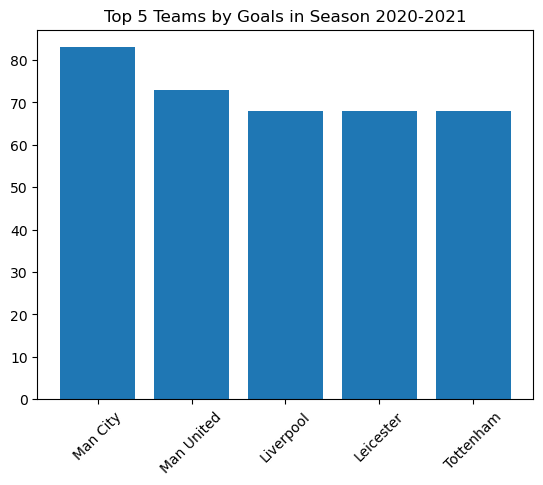

In [316]:
import matplotlib.pyplot as plt

top5 = team_goals.sort_values("Total_Goals", ascending=False).head(5)

plt.figure()
plt.bar(top5["Teams"], top5["Total_Goals"])
plt.xticks(rotation=45)
plt.title("Top 5 Teams by Goals in Season 2020-2021")
plt.show()

In [318]:
#same thing about yellow cards
home_yellows = df.groupby("HomeTeam")["HY"].sum()
away_yellows = df.groupby("AwayTeam")["AY"].sum()

total_yellows = home_yellows.add(away_yellows, fill_value=0)

total_yellows = total_yellows.reset_index()
total_yellows.columns = ["Team", "Total_Yellow_Cards"]

total_yellows.sort_values("Total_Yellow_Cards", ascending=False).head()

,Team,Total_Yellow_Cards
14,Sheffield United,73
7,Fulham,66
12,Man United,64
1,Aston Villa,63
8,Leeds,61


In [321]:
#we are about to create the league table for that season, using the goals_for and goals_against
#for each game we will give the points earned using the results.

#we calculate the home game points for each team
df["Home_points"] = np.where(df["FTR"] == "H", 3,
                           np.where(df["FTR"]=="D",1,0))
#and the away points
df["Away_points"] = np.where(df["FTR"] =="A",3,
                             np.where(df["FTR"]=="D",1,0))
#We then add those points to a home_table 
home_table = df.groupby("HomeTeam").agg({
    "Home_points":"sum",
    "FTHG":"sum",
    "FTAG":"sum"
}).reset_index()

home_table.columns = ["Team", "Points", "Goals_For", "Goals_Against"]
#as well as the away_table
away_table = df.groupby("AwayTeam").agg({
    "Away_points":"sum",
    "FTHG":"sum",
    "FTAG":"sum"
}).reset_index()

away_table.columns = ["Team", "Points", "Goals_For", "Goals_Against"]
#Finally we concatinate those two tables into the final league table!


#After some debugging, i found out that i had to run this script for the code to run correctly:

# enforce numeric, using coerce so if smth can't be converted to numeric, it takes NaN as a value
df["FTHG"] = pd.to_numeric(df["FTHG"], errors="coerce")
df["FTAG"] = pd.to_numeric(df["FTAG"], errors="coerce")

home = df.groupby("HomeTeam", as_index=False).agg(
    Pts=("Home_points","sum"),
    Goals_For=("FTHG","sum"),
    Goals_Against=("FTAG","sum")
    
).rename(columns={"HomeTeam":"Team"})

away = df.groupby("AwayTeam", as_index=False).agg(
    Pts=("Away_points","sum"),
    Goals_For=("FTAG","sum"),     # <-- correct for away
    Goals_Against=("FTHG","sum")     # <-- correct for away
    
).rename(columns={"AwayTeam":"Team"})

league = pd.concat([home, away], ignore_index=True).groupby("Team", as_index=False).sum()
league["Goal_Difference"] = league["Goals_For"] - league["Goals_Against"]

league = league.sort_values(["Pts","Goal_Difference","Goals_For"], ascending=False).reset_index(drop=True)
league.insert(0,"Position", league.index+1)
league


,Position,Team,Pts,Goals_For,Goals_Against,Goal_Difference
0,1,Man City,86,83,32,51
1,2,Man United,74,73,44,29
2,3,Liverpool,69,68,42,26
3,4,Chelsea,67,58,36,22
4,5,Leicester,66,68,50,18
5,6,West Ham,65,62,47,15
6,7,Tottenham,62,68,45,23
7,8,Arsenal,61,55,39,16
8,9,Leeds,59,62,54,8
9,10,Everton,59,47,48,-1


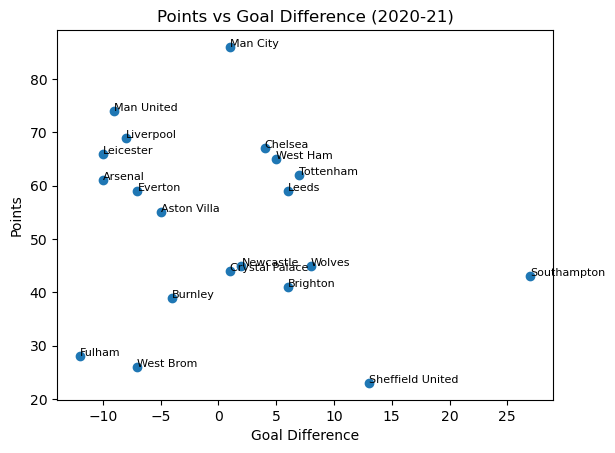

In [323]:
#visualize how points were distributed in relation to goal difference
plt.figure()
plt.scatter(league_table["Goal_Difference"], league_table["Points"])
for _, r in league_table.iterrows():
    plt.text(r["Goal_Difference"], r["Points"], r["Team"], fontsize=8)

plt.title("Points vs Goal Difference (2020-21)")
plt.xlabel("Goal Difference")
plt.ylabel("Points")
plt.show()

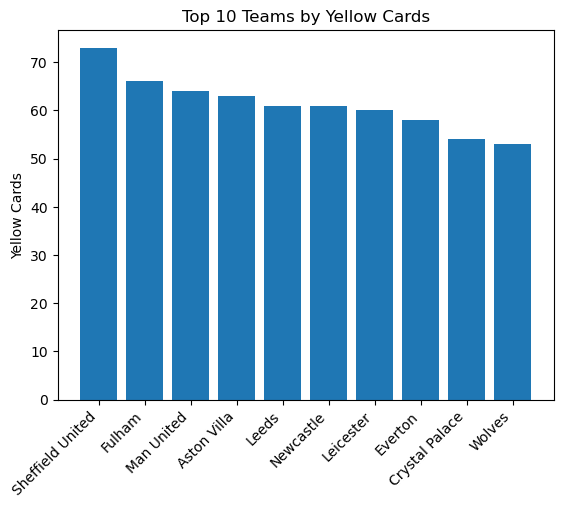

In [324]:
# total_yellows: DataFrame with columns ["Team","Total_Yellow_Cards"]
top10 = total_yellows.sort_values("Total_Yellow_Cards", ascending=False).head(10)

plt.figure()
plt.bar(top10["Team"], top10["Total_Yellow_Cards"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Teams by Yellow Cards")
plt.ylabel("Yellow Cards")
plt.show()